<a href="https://colab.research.google.com/github/Ahmed-Camara/Facial-Emotion-Detection-using-deep-learning/blob/main/Human_face_emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from keras import regularizers
import random
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization,ZeroPadding2D, Activation
from tensorflow.keras.utils import plot_model 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image

In [2]:
import cv2
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
files = '/content/drive/MyDrive/DataSets/archive.zip'
#dataset_path = '/content/drive/MyDrive/ML_DL_practice/Human Face Emotion Detection/data/archive.zip'
with zipfile.ZipFile(files, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset/')

In [5]:
train_path = '/content/dataset/train'
test_path = '/content/dataset/test'

In [6]:
os.listdir(train_path)

['happy', 'disgust', 'fear', 'neutral', 'surprise', 'sad', 'angry']

#### Hyperparameters && parameters

In [20]:
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
epochs = 50
base_learning_rate = 0.001
fine_learning_rate = 1e-5
dropout_factor = 0.5
decay=1e-6
loss_function=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate,decay=decay)
fine_optimizer = tf.keras.optimizers.Adam(learning_rate=fine_learning_rate,decay=decay)
metrics=['accuracy']

#### Load data

In [8]:
train_dataset = image_dataset_from_directory(train_path,shuffle=True, batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE,validation_split=0.2,subset='training', seed = 42)
validation_dataset = image_dataset_from_directory(train_path,shuffle=True, 
                                                  batch_size=BATCH_SIZE,image_size=IMAGE_SIZE,validation_split=0.2
                                                  ,subset='validation', seed = 42)

test_dataset = image_dataset_from_directory(test_path,shuffle=True, 
                                                  batch_size=BATCH_SIZE,image_size=IMAGE_SIZE
                                                  , seed = 42)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [9]:
class_names = train_dataset.class_names
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

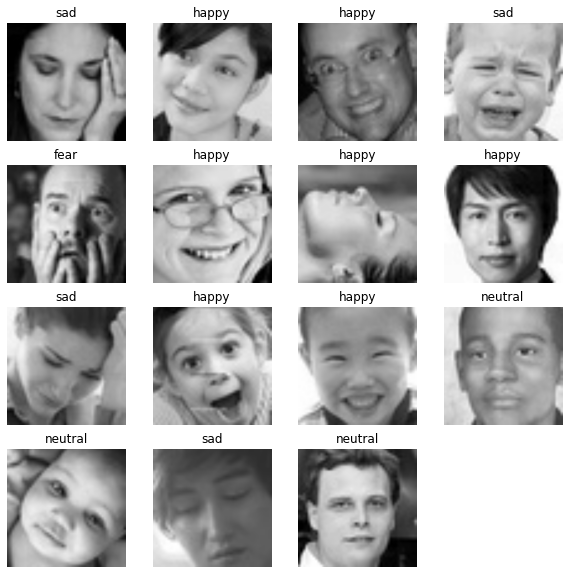

In [10]:

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(15):
        ax = plt.subplot(4,4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [12]:
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

def data_augmenter():
  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip('horizontal'))
  data_augmentation.add(RandomRotation(0.2))
  return data_augmentation

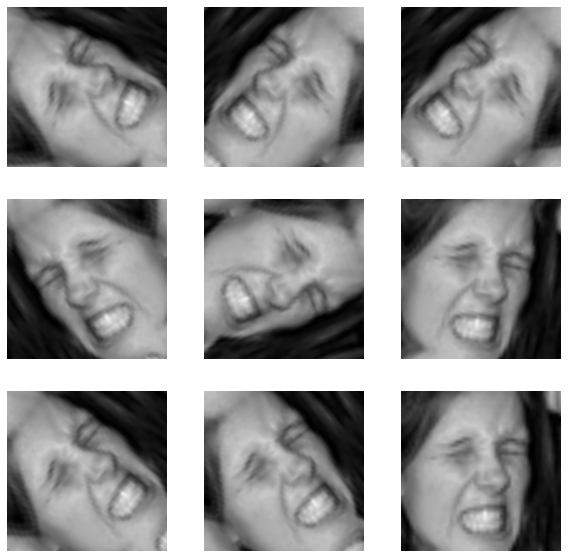

In [13]:
data_augmentation = data_augmenter()
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[2]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In this project, we are using only transfer learning to build our models. First, we will train our model on top of the architecture then we will use fine-tuning model to increase our accuracy.

In [14]:
def draw_diagram(hist):
  fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (16, 8))


  ax0.plot(hist.history['accuracy'])
  ax0.plot(hist.history['val_accuracy'])
  ax0.set_title('Model Accuracy')
  ax0.set_xlabel('Epochs')
  ax0.set_ylabel('Accuracy')
  ax0.legend(['train', 'test'], loc='upper left')



  ax1.plot(hist.history['loss'])
  ax1.plot(hist.history['val_loss'])
  ax1.set_title('Model Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend(['train', 'test'], loc='upper left')

  fig.savefig('/content/fer_resutls.png')
  plt.show()

In [15]:
IMAGE_SHAPE = IMAGE_SIZE + (3,)

In [21]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,
                                              patience=5,restore_best_weights=True)
callbacks = [stop_early]

# Transfer Learning

In [23]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
base_model = tf.keras.applications.EfficientNetB1(input_shape=IMAGE_SHAPE,include_top=False,weights='imagenet')

base_model.trainable = False 
inputs = tf.keras.Input(shape=IMAGE_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dropout(dropout_factor)(x)
outputs = tfl.Dense(7)(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

history = model.fit(train_dataset,
                         epochs=epochs,batch_size=BATCH_SIZE,
                         validation_data=validation_dataset,callbacks=callbacks)

Epoch 1/50
359/359 [==============================] - 87s 219ms/step - loss: 1.7032 - accuracy: 0.3245 - val_loss: 1.5323 - val_accuracy: 0.4231
Epoch 2/50
359/359 [==============================] - 76s 211ms/step - loss: 1.5855 - accuracy: 0.3877 - val_loss: 1.4819 - val_accuracy: 0.4391
Epoch 3/50
359/359 [==============================] - 77s 212ms/step - loss: 1.5556 - accuracy: 0.3982 - val_loss: 1.4730 - val_accuracy: 0.4402
Epoch 4/50
359/359 [==============================] - 76s 212ms/step - loss: 1.5467 - accuracy: 0.4012 - val_loss: 1.4558 - val_accuracy: 0.4480
Epoch 5/50
359/359 [==============================] - 77s 212ms/step - loss: 1.5357 - accuracy: 0.4072 - val_loss: 1.4506 - val_accuracy: 0.4534
Epoch 6/50
359/359 [==============================] - 77s 213ms/step - loss: 1.5322 - accuracy: 0.4070 - val_loss: 1.4456 - val_accuracy: 0.4550
Epoch 7/50
359/359 [==============================] - 76s 212ms/step - loss: 1.5258 - accuracy: 0.4113 - val_loss: 1.4319 - val_ac

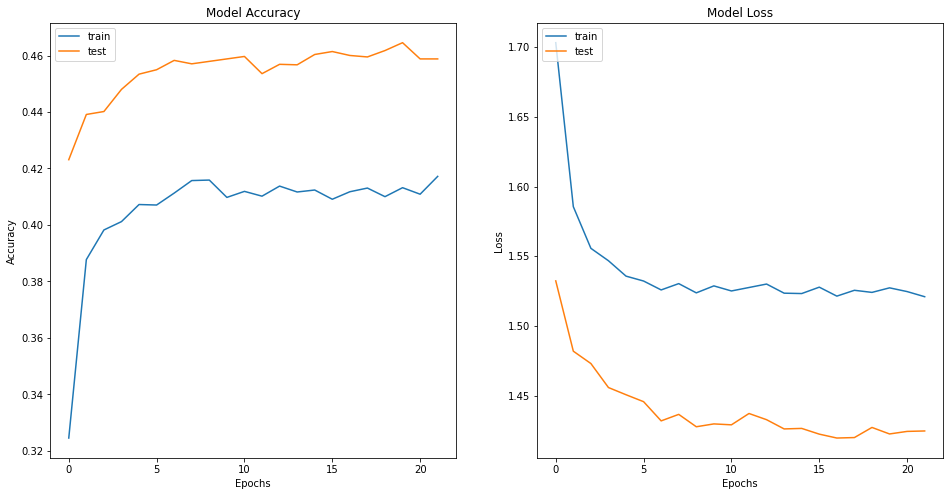

In [25]:
draw_diagram(history)

##### fine-tuning

In [26]:
base_model.trainable = True

fine_tune_at = 200


for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    

model.compile(loss=loss_function,
              optimizer = fine_optimizer,
              metrics=metrics)

fine_epochs = history.epoch[-1] + 100

history_fine = model.fit(train_dataset,
                         epochs=fine_epochs,batch_size=BATCH_SIZE,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,callbacks=callbacks)

Epoch 22/121
359/359 [==============================] - 130s 337ms/step - loss: 1.4417 - accuracy: 0.4512 - val_loss: 1.2950 - val_accuracy: 0.5039
Epoch 23/121
359/359 [==============================] - 119s 329ms/step - loss: 1.3541 - accuracy: 0.4840 - val_loss: 1.2310 - val_accuracy: 0.5243
Epoch 24/121
359/359 [==============================] - 119s 330ms/step - loss: 1.2970 - accuracy: 0.5070 - val_loss: 1.1950 - val_accuracy: 0.5414
Epoch 25/121
359/359 [==============================] - 119s 329ms/step - loss: 1.2536 - accuracy: 0.5245 - val_loss: 1.1639 - val_accuracy: 0.5569
Epoch 26/121
359/359 [==============================] - 118s 329ms/step - loss: 1.2169 - accuracy: 0.5362 - val_loss: 1.1403 - val_accuracy: 0.5626
Epoch 27/121
359/359 [==============================] - 119s 329ms/step - loss: 1.1941 - accuracy: 0.5492 - val_loss: 1.1283 - val_accuracy: 0.5656
Epoch 28/121
359/359 [==============================] - 118s 329ms/step - loss: 1.1642 - accuracy: 0.5601 - val_

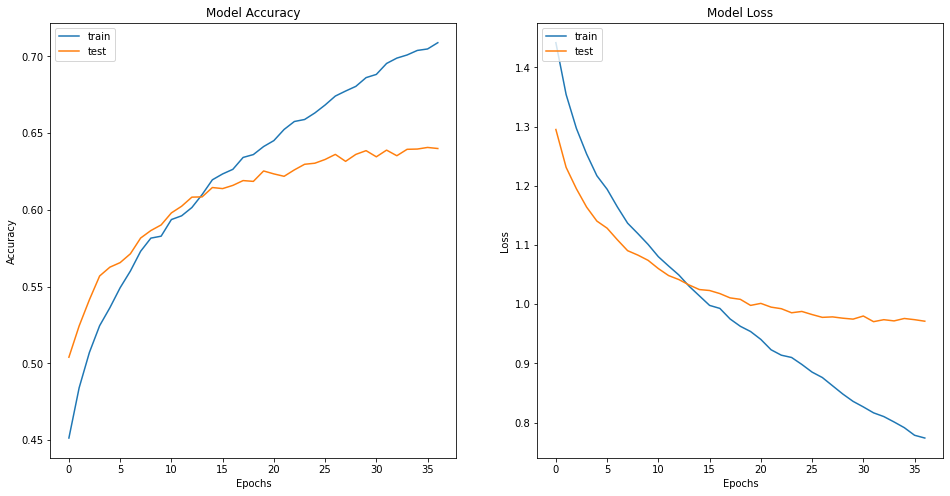

In [27]:
draw_diagram(history_fine)

In [31]:
model.save('human_emotion.h5')